In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [74]:
df = pd.read_csv('Sales_Transactions_Dataset_Weekly.csv')

In [132]:
df = df.loc[:, :'W51']
#columns after this contains normalized values

In [76]:
df.head()

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
0,P1,11,12,10,8,13,12,14,21,6,...,4,7,8,10,12,3,7,6,5,10
1,P2,7,6,3,2,7,1,6,3,3,...,2,4,5,1,1,4,5,1,6,0
2,P3,7,11,8,9,10,8,7,13,12,...,6,14,5,5,7,8,14,8,8,7
3,P4,12,8,13,5,9,6,9,13,13,...,9,10,3,4,6,8,14,8,7,8
4,P5,8,5,13,11,6,7,9,14,9,...,7,11,7,12,6,6,5,11,8,9


In [94]:
#we will convert this data into long form using melt method
melt = pd.melt(df, id_vars=['Product_Code'], var_name='week', value_name='sale')
melt.head()

,Product_Code,week,sale
0,P1,W0,11
1,P2,W0,7
2,P3,W0,7
3,P4,W0,12
4,P5,W0,8


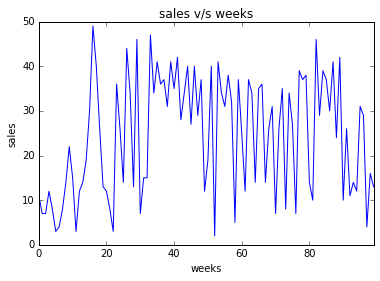

In [128]:
#Let's plot the week 0 data
melt[0:100]['sale'].plot()
plt.xlabel("weeks")
plt.ylabel("sales")
plt.title("sales v/s weeks")

In [167]:
#As it can be seen there is not much trend or seasonality in data
#thus we can directly use the random forest without detrending

In [95]:
#here we have to bring values into numbers
#we convert "P1" into 1 and "W1" into 1
# we will use extract method of series
melt.Product_Code = melt.Product_Code.str.extract(pat='(\d+)', expand=False).astype(int)
melt.week = melt.week.str.extract(pat='(\d+)', expand=False).astype(int)
melt.head()

,Product_Code,week,sale
0,1,0,11
1,2,0,7
2,3,0,7
3,4,0,12
4,5,0,8


In [86]:
#out dataset is ready
# Now we will perform some feature engineering

In [104]:
#create difference features
#group by product code and perform shift in sale
melt_2 = melt.copy()
melt_2['Last_1_week_sales'] = melt_2.groupby(['Product_Code'])['sale'].shift(1)
melt_2['Last_1_week_diff'] = melt_2.groupby(['Product_Code'])['Last_1_week_sales'].diff(1)
melt_2['Last_2_week_sales'] = melt_2.groupby(['Product_Code'])['sale'].shift(2)
melt_2['Last_2_week_diff'] = melt_2.groupby(['Product_Code'])['Last_2_week_sales'].diff(1)
melt_3 = melt_2.dropna()b

In [107]:
melt_3.head()

,Product_Code,week,sale,Last_1_week_sales,Last_1_week_diff,Last_2_week_sales,Last_2_week_diff
2433,1,3,8,10.0,-2.0,12.0,1.0
2434,2,3,2,3.0,-3.0,6.0,-1.0
2435,3,3,9,8.0,-3.0,11.0,4.0
2436,4,3,5,13.0,5.0,8.0,-4.0
2437,5,3,11,13.0,8.0,5.0,-3.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f40487ddeb8>,
      dtype=object)

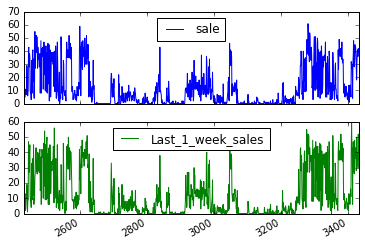

In [122]:
#Let's plot subplots to see if features make sense
melt_3[0:1000][['sale', 'Last_1_week_sales']].plot(subplots=True)

In [130]:
#It's clear that chosen feature has predictable power for sales

In [138]:
# error function
from sklearn.metrics import mean_squared_log_error
# we will take squareroot of the above error

In [144]:
#Now we will build a baseline model to compare our results
# we will train model using the data till week 43 and predict sales for week 43 to 53
# We will use Root Mean Squared Log Error to compare results

#Base line model
base_error = []
for week in range(43, 52):
    y_true = melt_3[melt_3['week'] == week]['sale'].values #series to numpy array
    y_pred = melt_3[melt_3['week'] == week]['Last_1_week_sales'].values #series to numpy array
    
    error = np.sqrt(mean_squared_log_error(y_true, y_pred))
    base_error.append(error)
    
    print("rmsle for week ", week, "is: ", error)

rmsle for week  43 is:  0.5079204595063594
rmsle for week  44 is:  0.5340885312370197
rmsle for week  45 is:  0.5234709783234434
rmsle for week  46 is:  0.5001778165328664
rmsle for week  47 is:  0.49138005062262924
rmsle for week  48 is:  0.5058450575478507
rmsle for week  49 is:  0.5054683594189949
rmsle for week  50 is:  0.5222037522547665
rmsle for week  51 is:  0.5524234818116678


In [145]:
# our model has to perform better than the base line model

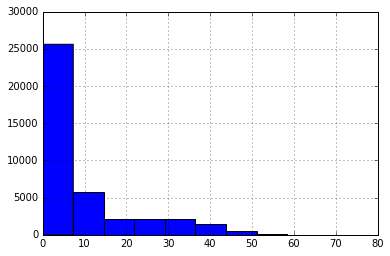

In [146]:
#Let's see the distribution of sales in data using histgram
melt_3['sale'].hist()

In [148]:
#It clearly says that sales for majority of item is quite low

In [149]:
from sklearn.ensemble import RandomForestRegressor

In [164]:
#regression model
model_error = []
for week in range(43, 52):
    train_data = melt_3[melt_3['week'] <= week]
    test_data = melt_3[melt_3['week'] == week]
    
    #training data
    x_train, y_train = train_data.drop('sale', axis=1), train_data['sale']
    x_test, y_test = test_data.drop('sale', axis=1), test_data['sale']
    
    #build model
    model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0) #-1 to use full cpu
    model.fit(x_train, y_train)
    
    #predict
    y_pred = model.predict(x_test)
    
    #compute error
    y_true = y_test.values
    error = np.sqrt(mean_squared_log_error(y_true, y_pred))
    model_error.append(error)
    
    #print and save error
    print("model rmsle for week ", week, "is: ", error)
    model_error.append(error)

model rmsle for week  43 is:  0.19196064636359297
model rmsle for week  44 is:  0.20944534147924374
model rmsle for week  45 is:  0.17806195470408945
model rmsle for week  46 is:  0.1986432174428974
model rmsle for week  47 is:  0.1907475927903476
model rmsle for week  48 is:  0.18508957061481573
model rmsle for week  49 is:  0.18728334887812692
model rmsle for week  50 is:  0.20519553736596
model rmsle for week  51 is:  0.2009207764428151


In [158]:
#That is awesome

In [159]:
#remember, random forest train our model using mean square error as error function.
#Let's change that into root log mean square

In [166]:
#regression model -> rmlse as error function for training
model_error = []
for week in range(43, 52):
    train_data = melt_3[melt_3['week'] <= week]
    test_data = melt_3[melt_3['week'] == week]
    
    #training data
    x_train, y_train = train_data.drop('sale', axis=1), train_data['sale']
    x_test, y_test = test_data.drop('sale', axis=1), test_data['sale']
    
    #build model
    model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0) #-1 to use full cpu
    model.fit(x_train, np.log1p(y_train)) #1p to avoid log(0)
    
    #predict
    y_pred = np.expm1(model.predict(x_test)) #taking exp to use rmlse 
    
    #compute error
    y_true = y_test.values
    error = np.sqrt(mean_squared_log_error(y_true, y_pred))
    model_error.append(error)
    
    #print and save error
    print("model rmsle for week ", week, "is: ", error)
    model_error.append(error)

model rmsle for week  43 is:  0.15656159792926477
model rmsle for week  44 is:  0.16761415427729326
model rmsle for week  45 is:  0.1515976446781353
model rmsle for week  46 is:  0.16566315240020515
model rmsle for week  47 is:  0.1535825151202442
model rmsle for week  48 is:  0.15949818517220474
model rmsle for week  49 is:  0.1598867014050453
model rmsle for week  50 is:  0.16966993138730757
model rmsle for week  51 is:  0.17232046688600317


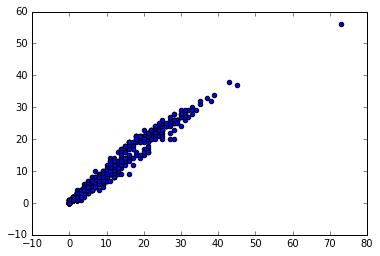

In [173]:
#As we can see the results are impressive.
#Let's plot the predicted sales and actual sales in scatter plot for week 51 predictions
true_sales = y_true #last entry
pred_sales = np.round(y_pred) #last entry
plt.scatter(true_sales, pred_sales)
plt.xlabel("Actual sales")
plt

In [174]:
# Model is performing good enough
# We can see as sales is higher than 30/35, model is giving higher errros. 
# We can investigate into data and see if there is some trend or some other reason for that

In [169]:
#Ideas to improve performance
#1. Investigate the items(sales) for which model is not performing very well 
#2. increase number of classifiers and use bagging/boosting/pruning techniques
#3. Increase more features
#4. Try a neural network and ensemble with GBM
#5. Try improved Random forest algorithms